# 📓 Notebook - Teori & Praktik Bab 5: Support Vector Machines (SVM)

Selamat datang di notebook panduan lengkap untuk Bab 5. Bab ini membahas salah satu model Machine Learning yang paling kuat dan serbaguna: **Support Vector Machines (SVM)**.

SVM mampu melakukan klasifikasi (linear atau non-linear), regresi, dan bahkan deteksi anomali. Model ini sangat cocok untuk dataset yang kompleks namun berukuran kecil atau sedang.

Notebook ini membahas:
1.  **Klasifikasi SVM Linear** (Konsep Margin, Soft vs Hard Margin)
2.  **Klasifikasi SVM Non-Linear** (Fitur Polinomial, Trik Kernel)
3.  **Regresi SVM**


In [9]:
# Setup awal: Impor library yang dibutuhkan
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

# Muat dataset Iris untuk contoh klasifikasi
iris = datasets.load_iris()
X_iris = iris["data"][:, (2, 3)]  # Hanya gunakan petal length dan petal width
y_setosa = (iris["target"] == 0).astype(np.float64)  # 1 jika Iris setosa, 0 jika bukan
y_versicolor = (iris["target"] == 1).astype(np.float64) # 1 jika Iris versicolor
y_virginica = (iris["target"] == 2).astype(np.float64) # 1 jika Iris virginica

## 1. Klasifikasi SVM Linear

### 1.1 Teori: Klasifikasi Margin Maksimal (Large Margin Classification)

**Teori :**

Ide fundamental di balik SVM adalah **Klasifikasi Margin Maksimal**. Bayangkan Anda memiliki dua kelas data. Alih-alih hanya menggambar *garis* yang memisahkan keduanya, SVM mencoba menemukan "jalan" atau "margin" terluas yang memisahkan kedua kelas tersebut.

Model SVM adalah garis tengah dari jalan tersebut. Keuntungan dari margin yang lebar adalah model ini akan **menggeneralisasi dengan baik** pada data baru, karena ia tidak terlalu "dekat" dengan data latih manapun.

Instance (data) yang berada di *tepi* jalan disebut **Support Vectors**. Merekalah yang "mendukung" atau menentukan di mana batas keputusan (jalan) itu berada. Menambahkan lebih banyak data *di luar* jalan tidak akan mengubah batas keputusan sama sekali.

### 1.2 Teori: Soft Margin vs Hard Margin

1.  **Hard Margin Classification:**
    Secara ketat mengharuskan *semua* instance berada di luar jalan dan di sisi yang benar. Ini memiliki dua masalah utama:
    a. Hanya berfungsi jika data dapat dipisahkan secara linear (linearly separable).
    b. Sangat sensitif terhadap *outlier* (data pencilan). Satu outlier saja bisa mengubah seluruh batas keputusan.

2.  **Soft Margin Classification (Lebih Fleksibel):**
    Ini adalah pendekatan yang lebih realistis dan umum digunakan. Tujuannya adalah mencari **keseimbangan** antara menjaga "jalan" selebar mungkin dan membatasi **pelanggaran margin** (*margin violations*). Pelanggaran margin adalah instance yang berakhir di tengah jalan atau bahkan di sisi yang salah.

    Di Scikit-Learn, keseimbangan ini dikendalikan oleh hyperparameter **`C`**:
    * **`C` rendah:** Jalan lebar, lebih banyak pelanggaran margin (model lebih *teregulasi*, generalisasi lebih baik, risiko *underfitting*).
    * **`C` tinggi:** Jalan sempit, lebih sedikit pelanggaran margin (model kurang *teregulasi*, lebih sensitif pada data latih, risiko *overfitting*).

### 1.3 Kode: Menjalankan SVM Linear

**PENTING:** SVM sangat sensitif terhadap skala fitur. Kita **HARUS** melakukan *feature scaling* (misalnya `StandardScaler`) sebelum melatih SVM.

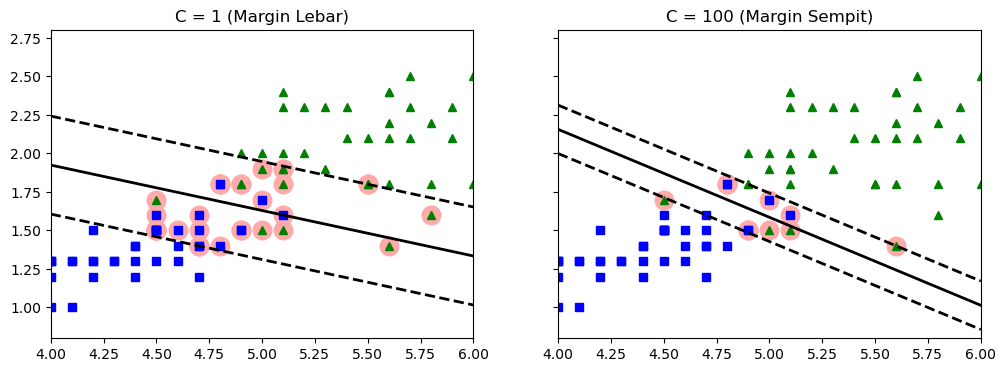

In [10]:
# Kita akan menggunakan dataset Iris Setosa vs Versicolor (yang tidak linear)
# untuk menunjukkan efek C pada model LinearSVC.

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # 1 jika Iris Virginica, 0 jika bukan

# Buat pipeline yang melakukan scaling lalu melatih LinearSVC
# LinearSVC adalah implementasi SVM Linear yang cepat dan dioptimalkan.
# Kita set max_iter=10000 agar tidak ada warning konvergensi
svm_clf_c1 = Pipeline([
    ("scaler", StandardScaler()), 
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42, max_iter=10000))
])

svm_clf_c100 = Pipeline([
    ("scaler", StandardScaler()), 
    ("linear_svc", LinearSVC(C=100, loss="hinge", random_state=42, max_iter=10000))
])

svm_clf_c1.fit(X, y)
svm_clf_c100.fit(X, y)

# Fungsi untuk plot
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.named_steps["linear_svc"].coef_[0]
    b = svm_clf.named_steps["linear_svc"].intercept_[0]

    # Dapatkan scaler-nya
    scaler = svm_clf.named_steps["scaler"]
    
    # Hati-hati: W dan b didapat dari data yang sudah di-scale
    # Kita harus "un-scale" garisnya untuk di-plot di atas data asli
    x0 = np.linspace(xmin, xmax, 200)
    # w0*x0_scaled + w1*x1_scaled + b = 0
    # x1_scaled = -(w0*x0_scaled + b) / w1
    # (x1 - mean1) / std1 = -(w0 * (x0 - mean0) / std0 + b) / w1
    # x1 = (-(w0 * (x0 - mean0) / std0 + b) / w1) * std1 + mean1
    
    mean0 = scaler.mean_[0]
    std0 = scaler.scale_[0]
    mean1 = scaler.mean_[1]
    std1 = scaler.scale_[1]

    x0_scaled = (x0 - mean0) / std0
    
    decision_boundary = -(w[0] * x0_scaled + b) / w[1]
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    # Un-scale kembali y (x1) untuk plotting
    decision_boundary = decision_boundary * std1 + mean1
    gutter_up = gutter_up * std1 + mean1
    gutter_down = gutter_down * std1 + mean1
    
    # Cari support vectors (yang ada di dalam gutter/jalan)
    # LinearSVC tidak mengekspos support_vectors_ secara langsung
    # kita hitung manual
    y_pred = svm_clf.predict(X)
    t = y * 2 - 1
    X_scaled = scaler.transform(X)
    support_vectors_idx = (t * (X_scaled.dot(w) + b) < 1).ravel()
    plt.scatter(X[support_vectors_idx, 0], X[support_vectors_idx, 1], s=180, facecolors='#FFAAAA')
    
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

# Plot perbandingan C rendah vs C tinggi
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf_c1, 4, 6)
plt.title(f"C = {svm_clf_c1.named_steps['linear_svc'].C} (Margin Lebar)")
plt.axis([4, 6, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf_c100, 4, 6)
plt.title(f"C = {svm_clf_c100.named_steps['linear_svc'].C} (Margin Sempit)")
plt.axis([4, 6, 0.8, 2.8])

plt.show()

# Insight: C=1 (kiri) memiliki margin lebih lebar dan lebih banyak pelanggaran (titik merah). 
# C=100 (kanan) hampir tidak memiliki pelanggaran, tapi marginnya jauh lebih sempit.

## 2. Klasifikasi SVM Non-Linear

**Teori (Penjelasan LLM):**
Banyak dataset tidak bisa dipisahkan dengan garis lurus. Ada dua cara utama SVM menanganinya:

### 2.1 Teori: Solusi 1 - Fitur Polinomial

**Teori :**
Kita bisa menambahkan fitur baru yang merupakan pangkat dari fitur yang ada (seperti di Bab 4). Misalnya, jika kita punya fitur `x1`, kita bisa menambahkan fitur baru `x2 = (x1)²`. Ini dapat membuat dataset yang tadinya tidak linear menjadi linear di dimensi yang lebih tinggi.

Masalahnya, jika `degree`-nya tinggi, jumlah fitur bisa meledak dan model menjadi sangat lambat.

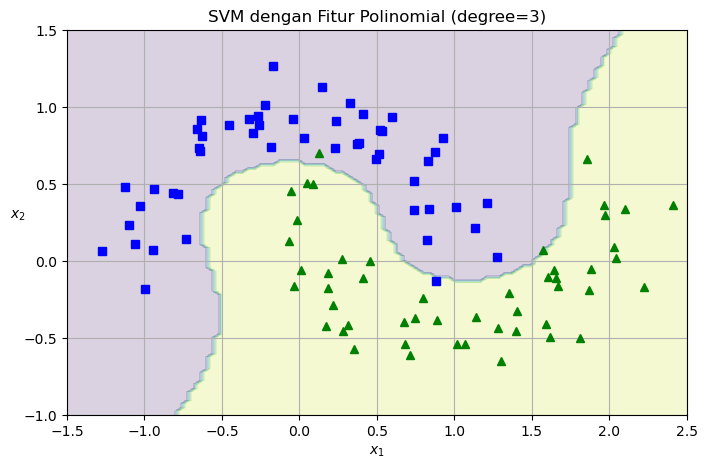

In [11]:
# Buat dataset non-linear (make_moons)
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

# Fungsi plot data moons
def plot_moons(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

# Fungsi plot boundary non-linear
def plot_nl_decision_boundary(clf, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.2)

# Coba gunakan fitur polinomial dan LinearSVC
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42, max_iter=10000))
])

polynomial_svm_clf.fit(X, y)

plt.figure(figsize=(8, 5))
plot_nl_decision_boundary(polynomial_svm_clf, axes=[-1.5, 2.5, -1, 1.5])
plot_moons(X, y, axes=[-1.5, 2.5, -1, 1.5])
plt.title("SVM dengan Fitur Polinomial (degree=3)")
plt.show()

### 2.2 Teori: Solusi 2 - Trik Kernel (The Kernel Trick)

**Teori :**
Ini adalah "keajaiban" SVM. Trik kernel memungkinkan kita mendapatkan hasil yang sama *seolah-olah* kita menambahkan banyak fitur (bahkan tak terhingga) tanpa benar-benar harus menambahkannya. Ini menghemat daya komputasi secara besar-besaran.

Kita hanya perlu mengganti `LinearSVC` dengan `SVC` dan memilih `kernel`:

#### Kernel Polinomial
Menggunakan `kernel="poly"`. Jika `degree=d`, ini akan mensimulasikan penambahan semua kombinasi fitur polinomial hingga derajat `d`. Parameter `coef0` (koefisien independen) mengontrol seberapa besar pengaruh polinomial derajat tinggi vs. rendah.

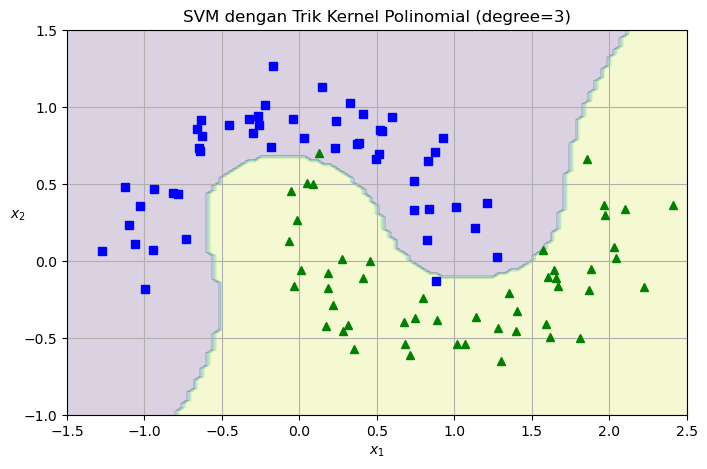

In [12]:
# Menggunakan Trik Kernel Polinomial (jauh lebih efisien)
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X, y)

plt.figure(figsize=(8, 5))
plot_nl_decision_boundary(poly_kernel_svm_clf, axes=[-1.5, 2.5, -1, 1.5])
plot_moons(X, y, axes=[-1.5, 2.5, -1, 1.5])
plt.title("SVM dengan Trik Kernel Polinomial (degree=3)")
plt.show()

### 2.3 Teori: Kernel RBF (Gaussian RBF)

**Teori:**
Kernel RBF adalah kernel yang paling populer dan serbaguna. Ia bekerja dengan mengukur "kemiripan" setiap instance dengan *landmark* (secara implisit, setiap instance menjadi landmark).

Ini adalah pilihan *default* yang baik untuk `SVC`.

Kernel RBF memiliki hyperparameter **`gamma` (γ)** yang penting:
- **`gamma` rendah:** Kurva "lonceng" (Gaussian) lebar. Setiap instance punya pengaruh yang luas. Batas keputusan sangat mulus. (Risiko **Underfitting**).
- **`gamma` tinggi:** Kurva "lonceng" sempit. Setiap instance punya pengaruh yang sempit/lokal. Batas keputusan sangat berliku-liku mengikuti data. (Risiko **Overfitting**).

Singkatnya, `gamma` dan `C` adalah hyperparameter regularisasi utama untuk RBF SVM. Keduanya bekerja berlawanan: menaikkan `gamma` atau `C` akan *mengurangi* regularisasi (meningkatkan risiko overfitting), sedangkan menurunkannya akan *menambah* regularisasi (meningkatkan risiko underfitting).

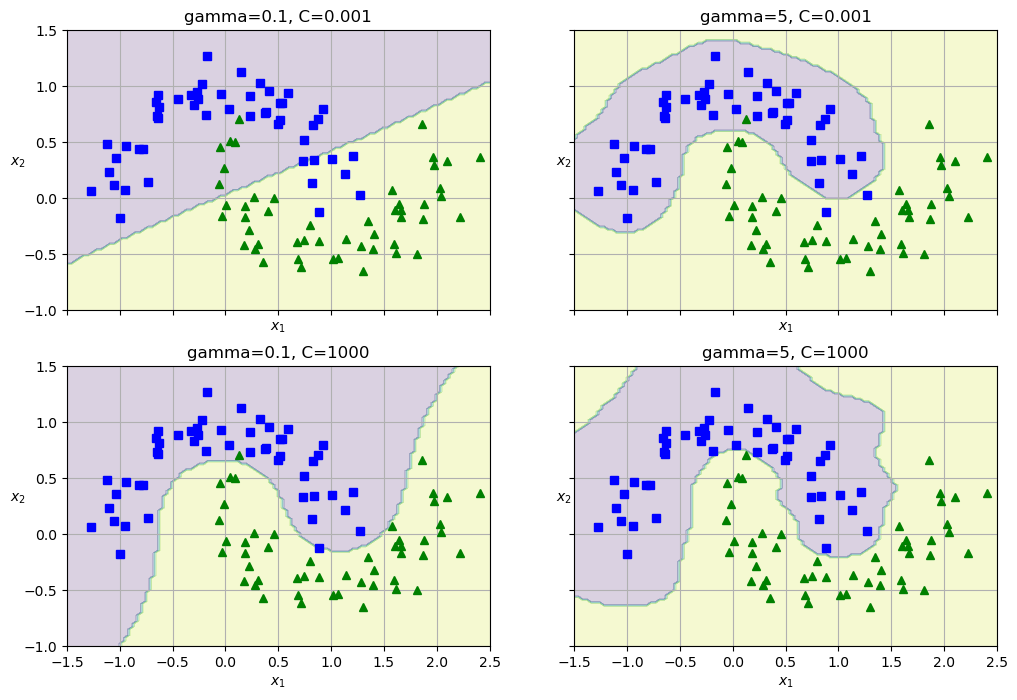

In [13]:
# Tunjukkan efek dari gamma dan C
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000

models = (
    SVC(kernel="rbf", gamma=gamma1, C=C1),
    SVC(kernel="rbf", gamma=gamma2, C=C1),
    SVC(kernel="rbf", gamma=gamma1, C=C2),
    SVC(kernel="rbf", gamma=gamma2, C=C2)
)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharey=True, sharex=True)

for i, model in enumerate(models):
    plt.sca(axes[i // 2, i % 2])
    # Buat pipeline untuk scaling
    clf = Pipeline([("scaler", StandardScaler()), ("svm_clf", model)])
    clf.fit(X, y)
    plot_nl_decision_boundary(clf, axes=[-1.5, 2.5, -1, 1.5])
    plot_moons(X, y, axes=[-1.5, 2.5, -1, 1.5])
    plt.title(f"gamma={model.gamma}, C={model.C}")

plt.show()

# Insight:
# Kiri atas (gamma=0.1, C=0.001): UNDERFITTING (terlalu teregulasi)
# Kanan bawah (gamma=5, C=1000): OVERFITTING (kurang teregulasi, terlalu mengikuti data)
# Pilihan yang baik biasanya ada di antara keduanya.

## 3. Regresi SVM (SVM Regression)

**Teori :**
SVM juga bisa digunakan untuk regresi (memprediksi nilai numerik). Idenya **dibalik** dari klasifikasi.

Alih-alih mencari "jalan" terluas *di antara* kelas, SVM Regresi (SVR) mencoba mencari "jalan" dengan lebar tertentu yang **memuat sebanyak mungkin instance *di dalamnya***.

Lebar jalan ini dikontrol oleh hyperparameter **`epsilon` (ε)**. Menambahkan data *di dalam* jalan tidak memengaruhi prediksi. Oleh karena itu, model ini disebut *ε-insensitive*.

Instance yang berada *di luar* jalan (di luar margin) adalah *support vectors* untuk regresi.

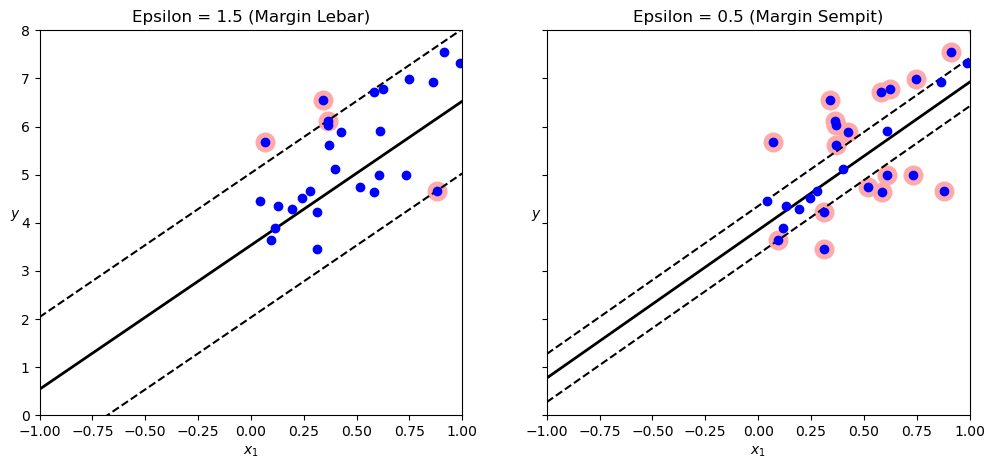

In [14]:
# Buat data linear acak untuk regresi
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

# Latih dua model SVR (Support Vector Regression)
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42, max_iter=10000)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42, max_iter=10000)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return off_margin 

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    
    svs = find_support_vectors(svm_reg, X, y)
    plt.scatter(X[svs], y[svs], s=180, facecolors='#FFAAAA') # Support vectors
    
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$y$", rotation=0)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [-1, 1, 0, 8])
plt.title(f"Epsilon = {svm_reg1.epsilon} (Margin Lebar)")
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [-1, 1, 0, 8])
plt.title(f"Epsilon = {svm_reg2.epsilon} (Margin Sempit)")
plt.show()

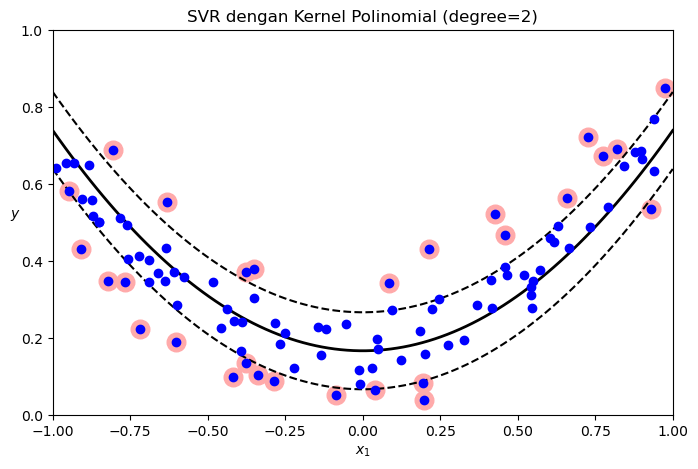

In [15]:
# Regresi SVM Non-Linear (menggunakan kernel)
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

# Gunakan SVR dengan kernel RBF
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
svm_poly_reg.fit(X, y)

plt.figure(figsize=(8, 5))
plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])
plt.title("SVR dengan Kernel Polinomial (degree=2)")
plt.show()

## Kesimpulan Bab 5: Poin-Poin Penting SVM

Bab ini memperkenalkan **Support Vector Machines (SVM)**, sebuah *algoritma supervised learning* yang sangat kuat dan serbaguna yang dapat digunakan untuk klasifikasi, regresi, dan deteksi anomali.

### 1. Ide Utama: Klasifikasi Margin Maksimal

Tujuan utama SVM adalah menemukan batas keputusan (garis atau *hyperplane*) yang tidak hanya memisahkan dua kelas, tetapi juga memiliki **margin** (jarak ke instance terdekat) yang sebesar mungkin.
* Model ini mencoba menemukan "jalan" terluas di antara dua kelas.
* Instance data yang terletak di tepi jalan ini disebut **Support Vectors**. Mereka adalah satu-satunya data yang menentukan batas keputusan.

### 2. Pentingnya Penskalaan Fitur (Feature Scaling)

* **Aturan Wajib:** SVM sangat sensitif terhadap skala fitur. Jika skala fitur berbeda jauh (misalnya, satu dari 0-1 dan satu lagi dari 0-1000), model akan bekerja dengan buruk.
* **Solusi:** Selalu gunakan `StandardScaler` di dalam `Pipeline` sebelum melatih SVM.

### 3. Soft Margin vs. Hard Margin

* **Hard Margin:** Mengharuskan semua data terpisah dengan sempurna. Ini sangat sensitif terhadap *outlier* dan hanya berfungsi jika data *linearly separable*.
* **Soft Margin (Default):** Pendekatan yang lebih fleksibel. Ia mencari keseimbangan antara margin yang lebar dan jumlah **pelanggaran margin** (*margin violations*).
* **Hyperparameter `C`:** Mengontrol keseimbangan ini.
    * **`C` rendah:** Regularisasi tinggi. Menghasilkan margin yang **lebar** tetapi mengizinkan lebih banyak pelanggaran (baik untuk menghindari *overfitting*).
    * **`C` tinggi:** Regularisasi rendah. Menghasilkan margin yang **sempit** dan berusaha keras meminimalkan pelanggaran (berisiko *overfitting*).

### 4. Klasifikasi Non-Linear dan Trik Kernel (Kernel Trick)

Untuk data yang tidak dapat dipisahkan oleh garis lurus, SVM menggunakan **Trik Kernel**.
* Trik Kernel adalah cara matematis cerdas untuk mendapatkan hasil *seolah-olah* kita telah menambahkan fitur-fitur kompleks (seperti fitur polinomial) tanpa benar-benar membuatnya. Ini sangat efisien.
* **Kernel Populer di `SVC`:**
    * **`kernel="poly"`:** Mensimulasikan fitur polinomial. Anda perlu mengatur `degree` (derajat).
    * **`kernel="rbf"` (Gaussian RBF):** Pilihan *default* yang paling serbaguna. Bisa menangani hampir semua dataset kompleks.

### 5. Hyperparameter untuk Kernel RBF

Saat menggunakan `kernel="rbf"`, dua hyperparameter terpenting adalah `C` dan `gamma`:
* **`gamma` (γ):** Mengontrol "bentuk" atau "kehalusan" batas keputusan.
    * **`gamma` rendah:** Batas keputusan mulus (risiko *underfitting*).
    * **`gamma` tinggi:** Batas keputusan berliku-liku mengikuti data (risiko *overfitting*).
* **`C`:** Mengontrol trade-off pelanggaran margin (seperti di poin 3).

### 6. Regresi SVM (SVR)

SVM juga bisa digunakan untuk regresi. Idenya dibalik:
* SVR mencoba mencari jalan yang bisa **memuat sebanyak mungkin instance *di dalam*-nya**.
* Lebar jalan ini dikontrol oleh **`epsilon` (ε)**.
* Model tidak "peduli" pada data yang ada di dalam jalan (batas epsilon), ini disebut *epsilon-insensitive*.